In [7]:
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [8]:
data = pd.read_csv('data/combined_data.csv',index_col=False)
data.head()

,address,city,type,bedroom,bathroom,price
0,8683 Via Mallorca,La Jolla,apartmentComplex,1,NaN,2456
1,400 Prospect St,La Jolla,apartmentComplex,1,NaN,5599
2,400 Prospect St,La Jolla,apartmentComplex,2,NaN,6008
3,7623 Eads Ave #7621-2E,La Jolla,apartmentComplex,1,1.0,2400
4,8506 Villa La Jolla Dr,La Jolla,apartmentComplex,1,NaN,2665


In [9]:
data.describe()

,bedroom,bathroom,price
count,613.000000,346.000000,613.000000
mean,1.933116,1.784682,3993.451876
std,1.044952,0.789806,4409.925426
min,0.000000,1.000000,295.000000
25%,1.000000,1.000000,2595.000000
50%,2.000000,2.000000,3100.000000
75%,3.000000,2.000000,4250.000000
max,5.000000,5.500000,90000.000000


Check the dependent variables are actually meaningful

In [10]:
prices = []
for c,df in data.groupby('city'):
    prices += [list(df['price'])]

In [11]:
f_oneway(prices[0],prices[1],prices[2],prices[3],prices[4],prices[5],prices[6],prices[7],prices[8],prices[9],prices[10],prices[11])

F_onewayResult(statistic=6.948583861205586, pvalue=4.110488789394614e-11)

In [12]:
prices = []
for c,df in data.groupby('bedroom'):
    print(c)
    prices += [list(df['price'])]

0
1
2
3
4
5


In [13]:
f_oneway(prices[0],prices[1],prices[2],prices[3],prices[4],prices[5])

F_onewayResult(statistic=28.703424407504034, pvalue=3.6260545675181526e-26)

In [14]:
data['type'].value_counts()

type
apartmentComplex    474
unknown               7
Name: count, dtype: int64

In [15]:
data['bathroom'].value_counts()

bathroom
1.0    135
2.0    124
2.5     32
3.0     25
1.5     16
3.5      7
4.0      4
5.5      1
4.5      1
5.0      1
Name: count, dtype: int64

Compare bedroom and bathroom to fill missing bathroom

In [16]:
data['bathroom'].isna().mean()

0.4355628058727569

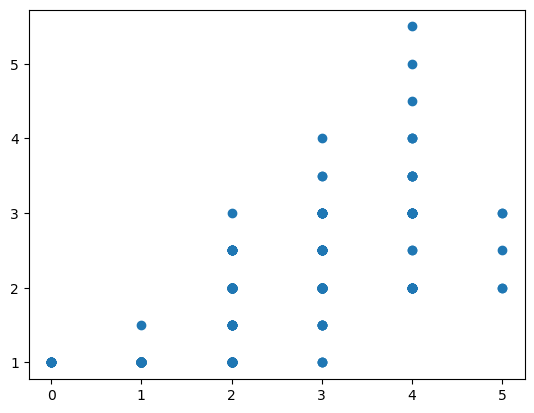

In [17]:
with_bath = data[data['bathroom'].isna() == False]
plt.scatter(with_bath['bedroom'],with_bath['bathroom'])

In [18]:
(with_bath['bedroom']-with_bath['bathroom']).mean()

0.44653179190751446

In [19]:
bed_to_bath = {}
for i in sorted(with_bath['bedroom'].unique()):
    df=with_bath[with_bath['bedroom'] == i]
    print("{} bedroom: ".format(i))
    print("average of {} bathroom: ".format(df['bathroom'].mean()))
    bed_to_bath[i] = df['bathroom'].mean()

0 bedroom: 
average of 1.0 bathroom: 
1 bedroom: 
average of 1.0063291139240507 bathroom: 
2 bedroom: 
average of 1.668141592920354 bathroom: 
3 bedroom: 
average of 2.2074468085106385 bathroom: 
4 bedroom: 
average of 2.8625 bathroom: 
5 bedroom: 
average of 2.5 bathroom: 


In [20]:
def round_to_half(num):
    num = num*2
    return round(num)/2

In [21]:
for k in bed_to_bath:
    bed_to_bath[k] = round_to_half(bed_to_bath[k])

In [22]:
bath_filled = data.copy()
def bath_fill(row):
    if np.isnan(row['bathroom']):
        row['bathroom'] = bed_to_bath[row['bedroom']]
    return row
bath_filled = bath_filled.apply(bath_fill,axis=1)
bath_filled.head()

,address,city,type,bedroom,bathroom,price
0,8683 Via Mallorca,La Jolla,apartmentComplex,1,1.0,2456
1,400 Prospect St,La Jolla,apartmentComplex,1,1.0,5599
2,400 Prospect St,La Jolla,apartmentComplex,2,1.5,6008
3,7623 Eads Ave #7621-2E,La Jolla,apartmentComplex,1,1.0,2400
4,8506 Villa La Jolla Dr,La Jolla,apartmentComplex,1,1.0,2665


In [23]:
def RMSE(obs, pred):
    return ((obs-pred)**2).mean()**0.5

In [24]:
def MAE(obs, pred):
    return abs(obs-pred).mean()

Case 1: Use city(one hot encoding), bedroom, and bathroom(filled) as a variable for decision tree

In [23]:
case1 = bath_filled.drop(['address','type'],axis=1)
case1_y = case1['price']
case1_x = case1.drop(['price'],axis=1)

In [24]:
city_enc = OneHotEncoder(handle_unknown='ignore')
city_enc.fit(case1_x[['city']])
print(city_enc.categories_)
city_coded = city_enc.transform(case1_x[['city']]).toarray()

[array(['Bay Ho', 'Clairemont Mesa East', 'Clairemont Mesa West',
       'Del Mar Heights', 'Kearny Mesa', 'La Jolla', 'Linda Vista',
       'Mira Mesa', 'North Clairemont', 'Pacific Beach',
       'Sorrento Valley', 'University City'], dtype=object)]


In [25]:
for i,c in enumerate(city_enc.categories_[0]):
    case1_x[c] = city_coded[:,i]

In [23]:
case1_x = case1_x.drop(['city'],axis=1)
case1_x.head()

,bedroom,bathroom,Bay Ho,Clairemont Mesa East,Clairemont Mesa West,Del Mar Heights,Kearny Mesa,La Jolla,Linda Vista,Mira Mesa,North Clairemont,Pacific Beach,Sorrento Valley,University City
0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
kf = KFold(n_splits=5)
for d in [2,3,4,5,6,7,8,9]:
    MAES = []
    RMSES = []
    print("Max depth with :{}".format(d))
    for i, (train_index, test_index) in enumerate(kf.split(case1_x)):
        train_X = case1_x.loc[train_index]
        train_y = case1_y.loc[train_index]
        test_X = case1_x.loc[test_index]
        test_y = case1_y.loc[test_index]
        tree = DecisionTreeRegressor(max_depth = d)
        tree.fit(train_X ,train_y)
        pred = tree.predict(test_X)
        MAES += [MAE(pred, test_y)]
        RMSES += [RMSE(pred, test_y)]
    print('average MAE: {}'.format(np.mean(MAES)))
    print('average RMSE: {}'.format(np.mean(RMSES)))

Max depth with :2
average MAE: 1415.9604379882003
average RMSE: 3169.2376953300686
Max depth with :3
average MAE: 1226.9863835334222
average RMSE: 3025.271163767407
Max depth with :4
average MAE: 1152.0544918905327
average RMSE: 2951.240819209202
Max depth with :5
average MAE: 1116.9759415336293
average RMSE: 2945.0143058827716
Max depth with :6
average MAE: 1083.5756037384813
average RMSE: 2923.6628047791028
Max depth with :7
average MAE: 1085.8425905692445
average RMSE: 2929.049728984385
Max depth with :8
average MAE: 1090.3348509718458
average RMSE: 2932.683770509153
Max depth with :9
average MAE: 1090.764906110967
average RMSE: 2921.692473624748


Case 2: Use bedroom, and bathroom(filled) as a variable for decision tree

In [25]:
case2 = bath_filled.drop(['city','address','type'],axis=1)
case2_y = case2['price']
case2_x = case2.drop(['price'],axis=1)

In [26]:
case2_x.head()

,bedroom,bathroom
0,1,1.0
1,1,1.0
2,2,1.5
3,1,1.0
4,1,1.0


In [27]:
kf = KFold(n_splits=5)
for d in [2,3,4,5,6,7,8,9]:
    MAES = []
    RMSES = []
    print("Max depth with :{}".format(d))
    for i, (train_index, test_index) in enumerate(kf.split(case1_x)):
        train_X = case2_x.loc[train_index]
        train_y = case2_y.loc[train_index]
        test_X = case2_x.loc[test_index]
        test_y = case2_y.loc[test_index]
        tree = DecisionTreeRegressor(max_depth = d)
        tree.fit(train_X ,train_y)
        pred = tree.predict(test_X)
        MAES += [MAE(pred, test_y)]
        RMSES += [RMSE(pred, test_y)]
    print('average MAE: {}'.format(np.mean(MAES)))
    print('average RMSE: {}'.format(np.mean(RMSES)))

Max depth with :2
average MAE: 1415.9604379882003
average RMSE: 3169.2376953300686
Max depth with :3
average MAE: 1196.2811714227344
average RMSE: 2981.039006680804
Max depth with :4
average MAE: 1123.7946714239124
average RMSE: 2877.5459440306327
Max depth with :5
average MAE: 1144.0674967439893
average RMSE: 2919.1426547581905
Max depth with :6
average MAE: 1164.8334914393372
average RMSE: 2986.674387250143
Max depth with :7
average MAE: 1167.2570288584186
average RMSE: 2990.7249126974557
Max depth with :8
average MAE: 1167.4213122584558
average RMSE: 2990.6386819678846
Max depth with :9
average MAE: 1167.4213122584558
average RMSE: 2990.6386819678846


Case 3: Use City(one hot encoded), bedroom, and bathroom(filled) as a variable for random forest

In [32]:
case3 = bath_filled.drop(['address','type'],axis=1)
case3_y = case3['price']
case3_x = case3.drop(['price'],axis=1)
city_enc = OneHotEncoder(handle_unknown='ignore')
city_enc.fit(case3_x[['city']])
print(city_enc.categories_)
city_coded = city_enc.transform(case3_x[['city']]).toarray()
for i,c in enumerate(city_enc.categories_[0]):
    case3_x[c] = city_coded[:,i]
case3_x = case3_x.drop(['city'],axis=1)

[array(['Bay Ho', 'Clairemont Mesa East', 'Clairemont Mesa West',
       'Del Mar Heights', 'Kearny Mesa', 'La Jolla', 'Linda Vista',
       'Mira Mesa', 'North Clairemont', 'Pacific Beach',
       'Sorrento Valley', 'University City'], dtype=object)]


In [2]:
from sklearn.ensemble import RandomForestRegressor

In [34]:
kf = KFold(n_splits=5)
for d in [2,3,4,5,6,7,8,9]:
    for c in ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']:
        MAES = []
        RMSES = []
        print("Max depth {} with criterion of {}".format(d,c))
        for i, (train_index, test_index) in enumerate(kf.split(case1_x)):
            train_X = case3_x.loc[train_index]
            train_y = case3_y.loc[train_index]
            test_X = case3_x.loc[test_index]
            test_y = case3_y.loc[test_index]
            tree = RandomForestRegressor(max_depth = d,criterion = c)
            tree.fit(train_X ,train_y)
            pred = tree.predict(test_X)
            MAES += [MAE(pred, test_y)]
            RMSES += [RMSE(pred, test_y)]
        print('average MAE: {}'.format(np.mean(MAES)))
        print('average RMSE: {}'.format(np.mean(RMSES)))

Max depth 2 with criterion of squared_error
average MAE: 1212.3025868382865
average RMSE: 2649.887532934225
Max depth 2 with criterion of absolute_error
average MAE: 1089.4766307477007
average RMSE: 2713.9977144663926
Max depth 2 with criterion of friedman_mse
average MAE: 1200.6843784950697
average RMSE: 2634.0088404321286
Max depth 2 with criterion of poisson
average MAE: 1130.3503730892376
average RMSE: 2629.514004513011
Max depth 3 with criterion of squared_error
average MAE: 1069.261912963718
average RMSE: 2456.998996631067
Max depth 3 with criterion of absolute_error
average MAE: 1023.0888185392508
average RMSE: 2483.2030922015156
Max depth 3 with criterion of friedman_mse
average MAE: 1080.1114939834144
average RMSE: 2523.9666502454315
Max depth 3 with criterion of poisson
average MAE: 1065.1274677429005
average RMSE: 2595.639701822818
Max depth 4 with criterion of squared_error
average MAE: 1035.5690586767482
average RMSE: 2517.7233395312746
Max depth 4 with criterion of absolu

Case 4: Use City(one hot encoded), bedroom, and bathroom(filled) as a variable for random forest

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
case4_x = case3_x.copy()
case4_y = case3_y.copy()

In [37]:
reg = LinearRegression().fit(case4_x, case4_y)
reg.score(case4_x, case4_y)

0.3801398244621842

In [38]:
MAES = []
RMSES = []
for i, (train_index, test_index) in enumerate(kf.split(case1_x)):
    train_X = case4_x.loc[train_index]
    train_y = case4_y.loc[train_index]
    test_X = case4_x.loc[test_index]
    test_y = case4_y.loc[test_index]
    reg = LinearRegression().fit(train_X ,train_y)
    pred = reg.predict(test_X)
    MAES += [MAE(pred, test_y)]
    RMSES += [RMSE(pred, test_y)]
print('average MAE: {}'.format(np.mean(MAES)))
print('average RMSE: {}'.format(np.mean(RMSES)))

average MAE: 1511.5883166499993
average RMSE: 3080.5864482467396


Final model

In [25]:
model = RandomForestRegressor(max_depth = 9,criterion = 'friedman_mse')

In [26]:
fin_data = bath_filled.drop(['address','type'],axis=1)
Y = fin_data['price']
X = fin_data.drop(['price'],axis=1)
city_enc = OneHotEncoder(handle_unknown='ignore')
city_enc.fit(fin_data[['city']])
print(city_enc.categories_)
city_coded = city_enc.transform(fin_data[['city']]).toarray()
for i,c in enumerate(city_enc.categories_[0]):
    X[c] = city_coded[:,i]
X = X.drop(['city'],axis=1)
X.head()

[array(['Bay Ho', 'Clairemont Mesa East', 'Clairemont Mesa West',
       'Del Mar Heights', 'Kearny Mesa', 'La Jolla', 'Linda Vista',
       'Mira Mesa', 'North Clairemont', 'Pacific Beach',
       'Sorrento Valley', 'University City'], dtype=object)]


,bedroom,bathroom,Bay Ho,Clairemont Mesa East,Clairemont Mesa West,Del Mar Heights,Kearny Mesa,La Jolla,Linda Vista,Mira Mesa,North Clairemont,Pacific Beach,Sorrento Valley,University City
0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,1.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
model.fit(X ,Y)
pred = model.predict(X)
print(RMSE(pred, Y))
print(MAE(pred, Y))

1442.6141367742641
647.0095868440447


In [28]:
pred[0]

3192.445791631228